In [42]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [43]:
import pathlib

#tgz is a type of compressed folder, tar is a utility to collect many files into one archive file.
#pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')
print(data_dir)

/Users/andrewhowe/.keras/datasets/flower_photos


In [44]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [45]:
roses = list(data_dir.glob('roses/*.jpg'))
print (roses[1])
# PIL.Image.open(str(roses[2]))

/Users/andrewhowe/.keras/datasets/flower_photos/roses/5777669976_a205f61e5b.jpg


In [46]:
batch_size = 32
img_height = 180
img_width = 180

training_dataset, validating_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset="both", 
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)
class_names = training_dataset.class_names
print (training_dataset.class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [47]:
#the images in the dataset is represented as a tensor of the shape (32, 180, 180, 3).
#This means 32 images, of shape 180x180x3 (last dimension refers to # of color channels. R G B.)
#labels represented as tensor of shape (32,) corresponding to the 32 images.
for images, labels in training_dataset:
    print (images.shape)
    print(labels.shape)
    break

#buffered prefetching - prevent I/O blocking.

#Dataset.cache keeps images in memory after they are loaded off the disk during first epoch. So we dont have to refetch after every epoch.
#Dataset.prefetch allows the preprocessing of data while the model execution is happening during training.
#tf.data.AUTOTUNE dynamically sets the buffer time during execution. this is used for prefetch.

training_dataset = training_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validating_dataset = validating_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

(32, 180, 180, 3)
(32,)


In [48]:
#Our RGB channel values are in [0, 255] range. we will standardize values to be in the 0, 1 range. 
#rescaling by dividing both values by 255.
#this will be applied when we create our model.
normalization_layer = layers.Rescaling(scale=1./255) # this is an example unused

In [49]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.RandomFlip(),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [58]:
training_history = model.fit(training_dataset, validation_data=validating_dataset,
                             epochs=10, batch_size=10)

Epoch 1/10
92/92 [==============================] - 12s 134ms/step - loss: 0.4443 - accuracy: 0.8304 - val_loss: 0.7134 - val_accuracy: 0.7493
Epoch 2/10
92/92 [==============================] - 12s 132ms/step - loss: 0.4158 - accuracy: 0.8457 - val_loss: 0.7454 - val_accuracy: 0.7452
Epoch 3/10
92/92 [==============================] - 13s 139ms/step - loss: 0.4091 - accuracy: 0.8481 - val_loss: 0.7326 - val_accuracy: 0.7534
Epoch 4/10
92/92 [==============================] - 13s 138ms/step - loss: 0.3921 - accuracy: 0.8501 - val_loss: 0.7736 - val_accuracy: 0.7330
Epoch 5/10
92/92 [==============================] - 13s 143ms/step - loss: 0.3566 - accuracy: 0.8706 - val_loss: 0.7179 - val_accuracy: 0.7793
Epoch 6/10
92/92 [==============================] - 13s 141ms/step - loss: 0.3445 - accuracy: 0.8750 - val_loss: 0.7180 - val_accuracy: 0.7561
Epoch 7/10
92/92 [==============================] - 12s 136ms/step - loss: 0.3451 - accuracy: 0.8716 - val_loss: 0.7025 - val_accuracy: 0.7602

<function matplotlib.pyplot.show(close=None, block=None)>

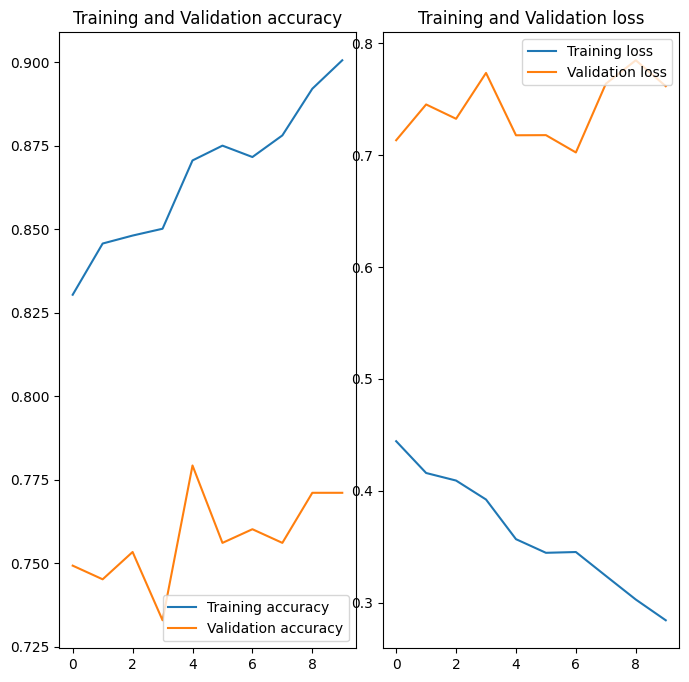

In [59]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
plt.figure(figsize=(8,8))
plt.subplot(1,4,(1,2)) 
plt.plot(range(10), acc, label='Training accuracy')
plt.plot(range(10), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,4,(3,4))#this makes the subplots wider.
plt.plot(range(10), loss, label='Training loss')
plt.plot(range(10), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

plt.show


In [62]:
test_flower_url = "https://hips.hearstapps.com/hmg-prod/images/close-up-of-blossoming-rose-flower-royalty-free-image-1580853844.jpg"
test_flower_path = keras.utils.get_file('flower_image', test_flower_url)

img = keras.utils.load_img(test_flower_path, target_size=(img_height, img_width))
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    f"This image likely belongs to {class_names[np.argmax(score)]} with a {np.max(score)*100} percent confidence."
)

1/1 [==============================] - 0s 13ms/step
This image likely belongs to roses with a 95.17557621002197 percent confidence.
